# Heterogenous Agent Neoclassical Model - HANC

**Table of contents**<a id='toc0_'></a>    
- 1. [Getting started](#toc1_)    
- 2. [Setup](#toc2_)    
  - 2.1. [Test household problem](#toc2_1_)    
- 3. [Step 1: Find Steady state](#toc3_)    
  - 3.1. [Direct approach](#toc3_1_)    
  - 3.2. [Indirect approach](#toc3_2_)    
  - 3.3. [Idiosyncratic productivity](#toc3_3_)    
  - 3.4. [Policy functions](#toc3_4_)    
  - 3.5. [Simulation](#toc3_5_)    
- 4. [Some analysis](#toc4_)    
  - 4.1. [Demand vs. supply of capital](#toc4_1_)    
  - 4.2. [Idiosyncratic risk and the steady state interest rate](#toc4_2_)    
  - 4.3. [Calibration](#toc4_3_)    
  - 4.4. [Drivers of wealth inequality](#toc4_4_)    
- 5. [Tests](#toc5_)    
- 6. [Step 2: Compute Jacobians](#toc6_)    
- 7. [Step 3a: Find non-linear transition_path](#toc7_)    
- 8. [Step 3b: Find linearized IRFs](#toc8_)    
- 9. [Decompose household behavior](#toc9_)    
- 10. [Custom shocks](#toc10_)    
  - 10.1. [Path](#toc10_1_)    
  - 10.2. [Initial distribution](#toc10_2_)    
- 11. [Step 4. Simulation](#toc11_)    
- 12. [Changing unknowns, shocks and targets](#toc12_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a simple Heterogenous Agent Neo-Classical (HANC) model** using the `GEModelTools` package.

See **HANC.pdf** for the model description. See **...\GEModelTools.pdf** for the documentation.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCModel import HANCModelClass

## 1. <a id='toc1_'></a>[Getting started](#toc0_)

Here we define a version of the model with the *minimal* about of information required to allocate everything and produce the directed acyclical graph (DAG).

In [2]:
from EconModel import EconModelClass
from GEModelTools import GEModelClass
import household_problem

class HANCModelClass_(EconModelClass,GEModelClass):    

    def settings(self):
        """ fundamental settings """

        # a. namespaces (typically not changed)
        self.namespaces = ['par','ini','sim','ss','path']
        
        # b. household
        self.grids_hh = ['a'] # grids
        self.pols_hh = ['a'] # policy functions
        self.inputs_hh = ['r','w'] # direct inputs
        self.inputs_hh_z = [] # transition matrix inputs
        self.outputs_hh = ['a','c','l'] # outputs
        self.intertemps_hh = ['vbeg_a'] # intertemporal variables

        # c. GE
        self.shocks = ['Gamma'] # exogenous shocks
        self.unknowns = ['K','L'] # endogenous unknowns
        self.targets = ['clearing_A','clearing_L'] # targets = 0
        self.blocks = [ # list of strings to block-functions
            'blocks.production_firm',
            'blocks.mutual_fund',
            'hh', # household block
            'blocks.market_clearing',
            ]

        self.solve_hh_backwards = household_problem.solve_hh_backwards

    def setup(self):
        """ set indepedent parameters """

        par = self.par

        par.Nfix = 3
        par.Nz = 7
        par.Na = 100

    def allocate(self):
        """ set dependent parameters and allocate"""

        self.allocate_GE()

model = HANCModelClass_() # initialize

In [3]:
model.info()

settings:
 par.py_hh = True
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c,l]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma]
 unknowns: [K,L]
 targets: [clearing_A,clearing_L]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L] -> [rK,w,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [r,w] -> [A_hh,C_hh,L_hh]
 market_clearing: [A,A_hh,L,L_hh,K,Y,C_hh] -> [I,clearing_A,clearing_L,clearing_Y]


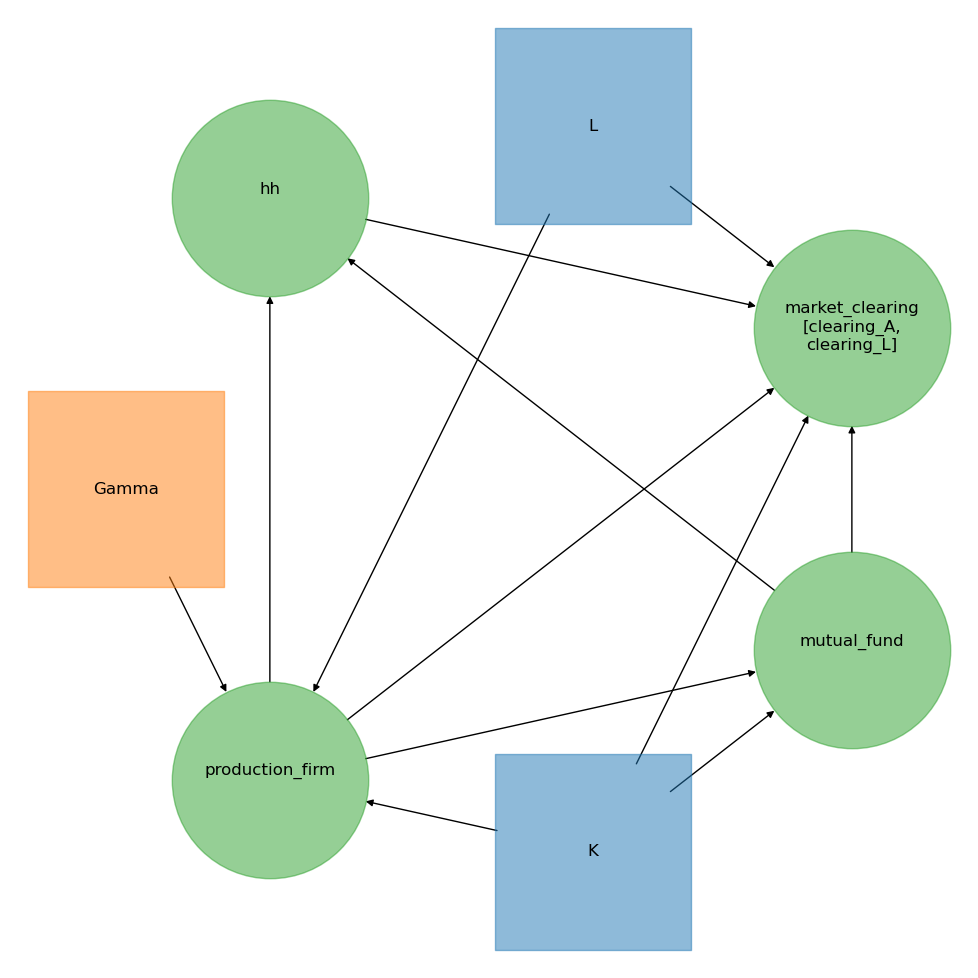

In [4]:
model.draw_DAG(figsize=(10,10))

**Note:** How can the code derive the DAG? Relies on the function `get_varnames`.

In [5]:
import blocks
from GEModelTools import get_varnames
get_varnames('blocks.production_firm')

('Gamma', 'K', 'L', 'rK', 'w', 'Y')

## 2. <a id='toc2_'></a>[Setup](#toc0_)

In [6]:
model = HANCModelClass(name='baseline') # create an instance of the model

Unpack:

In [7]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

**Pause:** Take a look at `.par` and `.ss`

**Question I:** Where does the variable names in `.ss` come from?

**Question II:** What explains the shapes below?

In [8]:
print(ss.a.shape)
print(ss.D.shape)
print(ss.z_trans.shape)

(3, 7, 300)
(3, 7, 300)
(3, 7, 7)


Show **information**:

In [9]:
model.info()

settings:
 par.py_hh = False
 par.py_blocks = True
 par.full_z_trans = False
 par.warnings = True
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w]
 inputs_hh_z: []
 outputs_hh: [a,c,l]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma]
 unknowns: [K,L]
 targets: [clearing_A,clearing_L]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L] -> [rK,w,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [r,w] -> [A_hh,C_hh,L_hh]
 market_clearing: [A,A_hh,L,L_hh,K,Y,C_hh] -> [I,clearing_A,clearing_L,clearing_Y]


Show **DAG**:

production_firm: [Gamma,K,L] -> [rK,w,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [r,w] -> [A_hh,C_hh,L_hh]
market_clearing: [A,A_hh,L,L_hh,K,Y,C_hh] -> [I,clearing_A,clearing_L,clearing_Y]


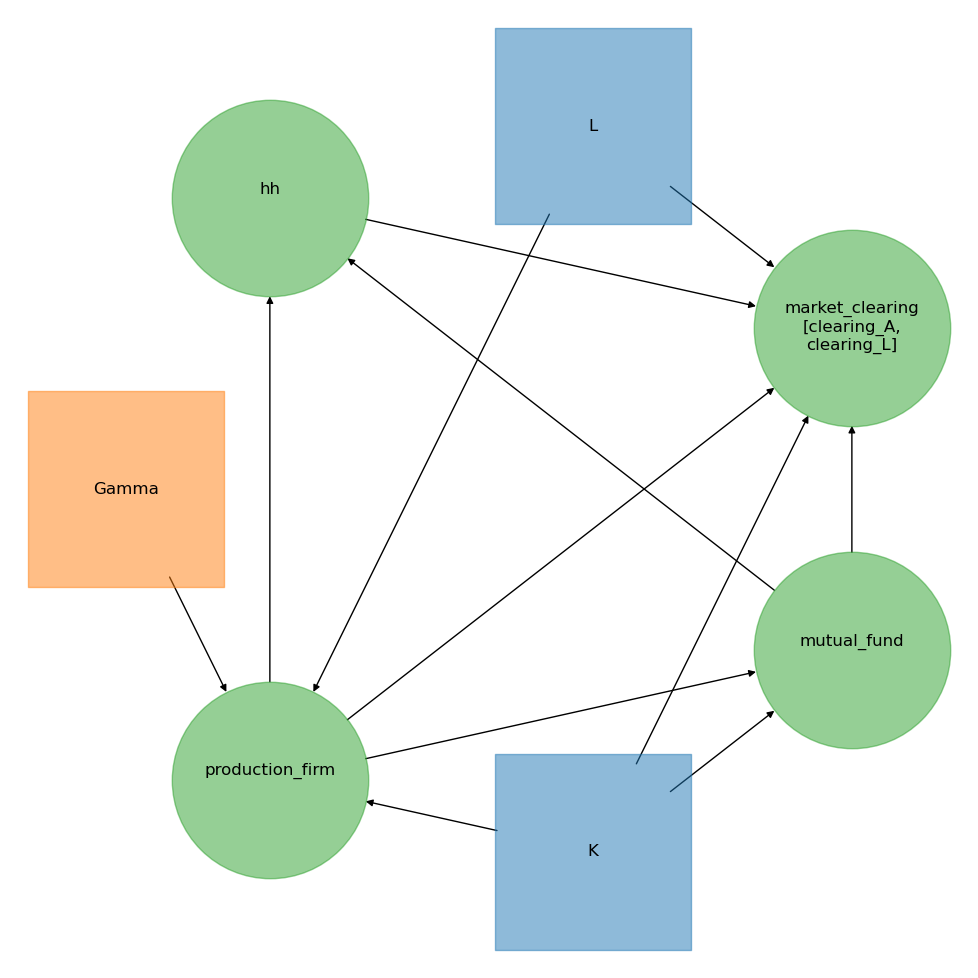

In [10]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

Detailed information:

In [11]:
print(model) # take a look inside

Modelclass: HANCModelClass
Name: baseline

namespaces: ['par', 'ini', 'sim', 'ss', 'path']
other_attrs: ['grids_hh', 'pols_hh', 'inputs_hh', 'inputs_hh_z', 'outputs_hh', 'intertemps_hh', 'shocks', 'unknowns', 'targets', 'varlist', 'blocks', 'jac', 'H_U', 'H_Z', 'jac_hh', 'IRF']
savefolder: saved
cpp_filename: None

par:
 Nbeta = 3 [int]
 Nphi = 1 [int]
 Nz = 7 [int]
 sigma = 2.0 [float]
 beta_mean = 0.975 [float]
 beta_delta = 0.01 [float]
 rho_z = 0.95 [float]
 sigma_psi = 0.09367496997597599 [float]
 phi_delta = 0.0 [float]
 Gamma_ss = nan [float]
 alpha = 0.36 [float]
 delta = nan [float]
 r_ss_target = 0.01 [float]
 w_ss_target = 1.0 [float]
 a_max = 500.0 [float]
 Na = 300 [int]
 jump_Gamma = -0.1 [float]
 rho_Gamma = 0.9 [float]
 std_Gamma = 0.01 [float]
 T = 500 [int]
 simT = 2000 [int]
 max_iter_solve = 50000 [int]
 max_iter_simulate = 50000 [int]
 max_iter_broyden = 100 [int]
 tol_solve = 1e-12 [float]
 tol_simulate = 1e-12 [float]
 tol_broyden = 1e-10 [float]
 py_hh = False [

### 2.1. <a id='toc2_1_'></a>[Test household problem](#toc0_)

Set the steady state values, which matter for the household:

In [12]:
ss.r = 0.01
ss.w = 1.00

**Solve the household problem** with `.solve_hh_ss()`:
    
1. Calls `.prepare_hh_ss()`
1. Calls `.solve_backwards_hh()` until convergence

In [13]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 17.4 secs [1287 iterations]


In [14]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 7.6 secs [1438 iterations]


**Note:** The first run will be slow due to compilation of the numba functions.

**Aggregate savings:**

In [15]:
print(f'{ss.A_hh = :.4f}')
print(f'{np.sum(ss.a*ss.D)/np.sum(ss.D) = :.4f}')
print(f'{np.sum(ss.a*ss.D) = :.4f}')

ss.A_hh = 2.7751
np.sum(ss.a*ss.D)/np.sum(ss.D) = 2.7751
np.sum(ss.a*ss.D) = 2.7751


## 3. <a id='toc3_'></a>[Step 1: Find Steady state](#toc0_)

**Task:** We need to find

1. All variables in `.ss`
1. The steady state policy functions `ss.a` and `ss.c`
1. The steady state distributions `ss.Dbeg` and `ss.D`
1. The steady state aggregates `ss.A_hh` and `ss.C_hh`

In `.prepare_hh_ss()` [called in `.solve_hh_ss()` used in `.find_ss()`] we specify:

1. All grids in `.par` (can depend on steady state values prior to the household problem)
1. Initial guess for `ss.Dbeg` when iterating *forwards*
1. Initial guess for `ss.vbeg_a` when iterating *backwards*

### 3.1. <a id='toc3_1_'></a>[Indirect approach](#toc0_)

In [16]:
model.set_ss_to_nan() # optional, but ensures everythin is set inside find_ss
model.find_ss(method='indirect',do_print=True)

household problem in ss solved in 1.2 secs [1287 iterations]
household problem in ss simulated in 0.7 secs [1438 iterations]

Implied K =  2.775
Implied Y =  1.562
Implied Gamma =  1.082
Implied delta =  0.193
Implied K/Y =  1.776
Discrepancy in A =   0.00000000
Discrepancy in L =   0.00000000
Discrepancy in Y =   0.00000000
found steady state in 1.9 secs


In [17]:
model.info(only_blocks=True,ss=True)

production_firm: [Gamma=1.08,K=2.78,L=1.00] -> [rK=0.20,w=1.00,Y=1.56]
mutual_fund: [K=2.78,rK=0.20] -> [A=2.78,r=0.01]
hh: [r=0.01,w=1.00] -> [A_hh=2.78,C_hh=1.03,L_hh=1.00]
market_clearing: [A=2.78,A_hh=2.78,L=1.00,L_hh=1.00,K=2.78,Y=1.56,C_hh=1.03] -> [I=0.53,clearing_A=0.00,clearing_L=0.00,clearing_Y=0.00]


### 3.1. <a id='toc3_1_'></a>[Direct approach](#toc0_)

In [18]:
model.set_ss_to_nan() # optional, but ensures everythin is set inside find_ss
model.find_ss(method='direct',do_print=True)

### step 1: broad search ###

guess ss.K = 1.0000
implied ss.r = 0.1968
implied ss.w = 0.6925
household problem in ss solved in 0.4 secs [309 iterations]
household problem in ss simulated in 0.0 secs [84 iterations]
implied ss.A_hh = 374.3095
clearing_A = -373.30947073

guess ss.K = 2.0000
implied ss.r = 0.0573
implied ss.w = 0.8888
household problem in ss solved in 0.6 secs [771 iterations]
household problem in ss simulated in 0.2 secs [758 iterations]
implied ss.A_hh = 451.4186
clearing_A = -449.41860730

guess ss.K = 3.0000
implied ss.r = 0.0001
implied ss.w = 1.0284
household problem in ss solved in 0.5 secs [605 iterations]
household problem in ss simulated in 0.1 secs [470 iterations]
implied ss.A_hh = 0.7438
clearing_A =   2.25615527

guess ss.K = 4.0000
implied ss.r = -0.0323
implied ss.w = 1.1407
household problem in ss solved in 0.2 secs [203 iterations]
household problem in ss simulated in 0.0 secs [134 iterations]
implied ss.A_hh = 0.0305
clearing_A =   3.96950067

guess ss

### 3.3. <a id='toc3_3_'></a>[Idiosyncratic productivity](#toc0_)

**Productivity states:** A closer look at the productivity process.

In [19]:
Dz = np.sum(ss.D,axis=2)
for i_fix in range(par.Nfix):
    
    beta = par.beta_grid[i_fix]
    print(f'{beta = :.2f}')
    for z,pr_z in zip(par.z_grid,Dz[i_fix]):
        print(f' Pr[z = {z:.4f}] = {pr_z:.4f}')

print('')

ss_mean_z = np.sum(par.z_grid*Dz)
ss_mean_log_z = np.sum(np.log(par.z_grid)*Dz)
print(f'mean(z): {ss_mean_z:.3f}')
assert np.isclose(ss_mean_z,1.0)

ss_std_z = np.sqrt(np.sum(Dz*(par.z_grid-ss_mean_z)**2))
print(f'std(z): {ss_std_z:.3f}')

ss_std_z = np.sqrt(np.sum(Dz*(np.log(par.z_grid)-ss_mean_log_z)**2))
print(f'std(log(z)): {ss_std_z:.3f}')

# note: the steady state transition matrix is in ss.z_trans

beta = 0.96
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052
beta = 0.97
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052
beta = 0.98
 Pr[z = 0.4585] = 0.0052
 Pr[z = 0.5858] = 0.0312
 Pr[z = 0.7484] = 0.0781
 Pr[z = 0.9561] = 0.1042
 Pr[z = 1.2215] = 0.0781
 Pr[z = 1.5605] = 0.0312
 Pr[z = 1.9936] = 0.0052

mean(z): 1.000
std(z): 0.304
std(log(z)): 0.300


**Grids:**

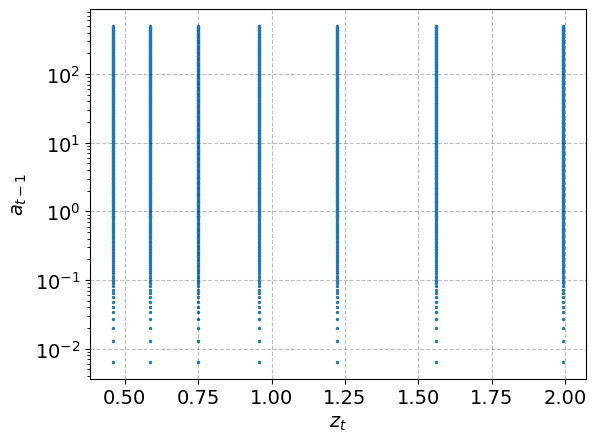

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

z_grid,a_grid = np.meshgrid(par.z_grid,par.a_grid,indexing='ij')
ax.scatter(z_grid,a_grid,2)

ax.set_yscale('log')
ax.set_xlabel('$z_t$')
ax.set_ylabel('$a_{t-1}$');

**Transition matrix for $z_t$:**

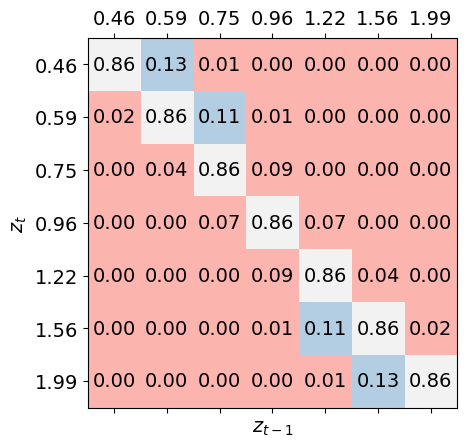

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(False)
i_fix = 0
h = ax.matshow(ss.z_trans[i_fix],cmap='Pastel1')

for (i, j), value in np.ndenumerate(ss.z_trans[i_fix]):
    ax.text(j, i, f'{value:0.2f}', ha='center', va='center')
    
z_labels = [f'{z:.2f}' for z in par.z_grid]
xaxis = np.arange(par.z_grid.size)
ax.set_xticks(xaxis)
ax.set_xticklabels(z_labels) 
ax.set_yticks(xaxis)
ax.set_yticklabels(z_labels) 

ax.set_xlabel('$z_{t-1}$')
ax.set_ylabel('$z_{t}$');

**Ergodic distribution:**

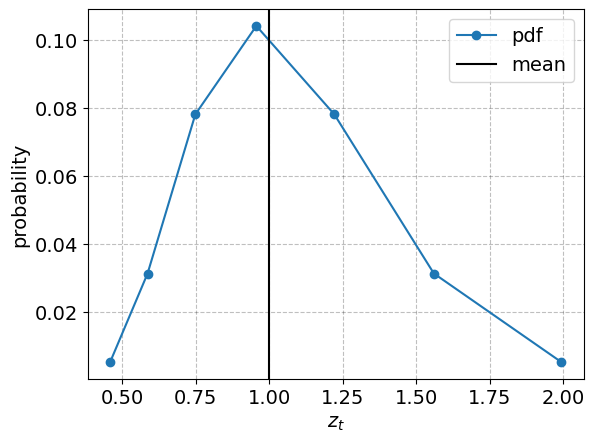

In [22]:
Dz = np.sum(ss.D,axis=2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
i_fix = 0
ax.plot(par.z_grid,Dz[i_fix],'-o',label='pdf')
ax.axvline(np.sum(par.z_grid*Dz),color='black',label='mean')
ax.set_xlabel('$z_t$')
ax.set_ylabel('probability')
ax.legend(frameon=True);

### 3.4. <a id='toc3_4_'></a>[Policy functions](#toc0_)

The steady state policy functions are in `ss.a` and `ss.c`.

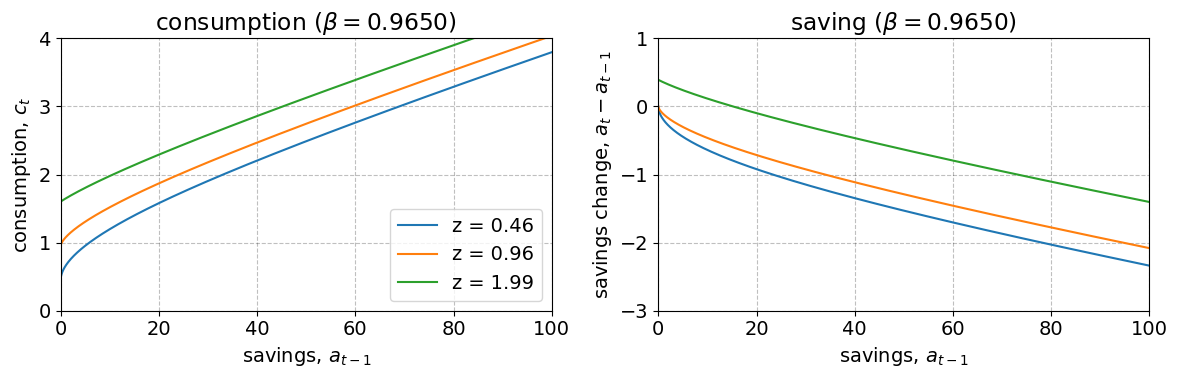

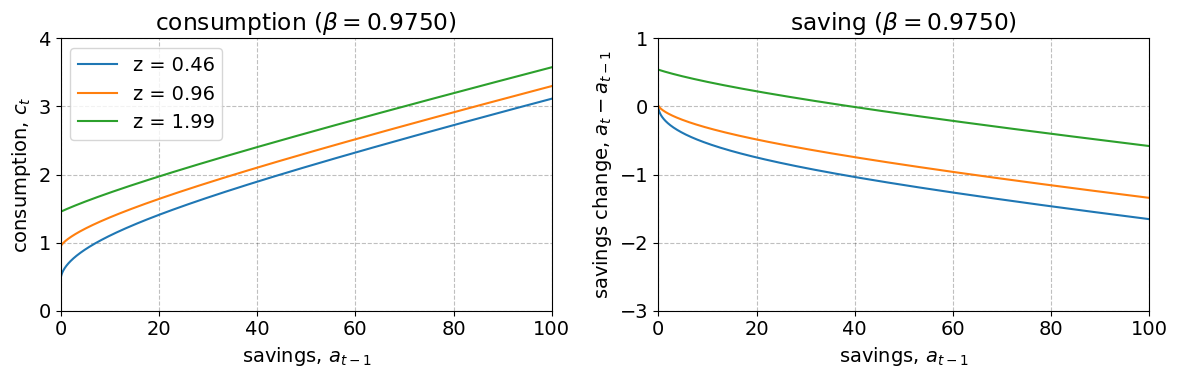

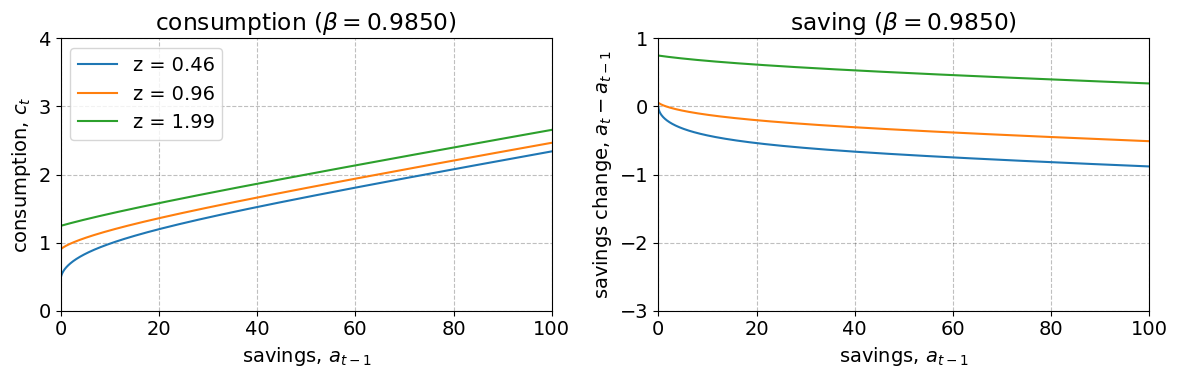

In [23]:
for i_beta,beta in enumerate(par.beta_grid):
    
    fig = plt.figure(figsize=(12,4),dpi=100)

    I = par.a_grid < 500

    # a. consumption
    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.c[i_beta,i_z,I],label=f'z = {z:.2f}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')
    ax.set_xlim(0,100)
    ax.set_ylim(0,4)

    # b. saving
    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving ($\\beta = {beta:.4f}$)')

    for i_z,z in enumerate(par.z_grid):
        if i_z%3 == 0 or i_z == par.Nz-1:
            ax.plot(par.a_grid[I],ss.a[i_beta,i_z,I]-par.a_grid[I],label=f'z = {z:.2f}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')
    ax.set_xlim(0,100)
    ax.set_ylim(-3,1)

    fig.tight_layout()
    fig.savefig(f'figs/c_func_{i_beta}.pdf')

### 3.5. <a id='toc3_5_'></a>[Simulation](#toc0_)

The steady state distribution is in `ss.D` where `ss.D.shape == [par.Nbeta,par.Nz,par.Na]`

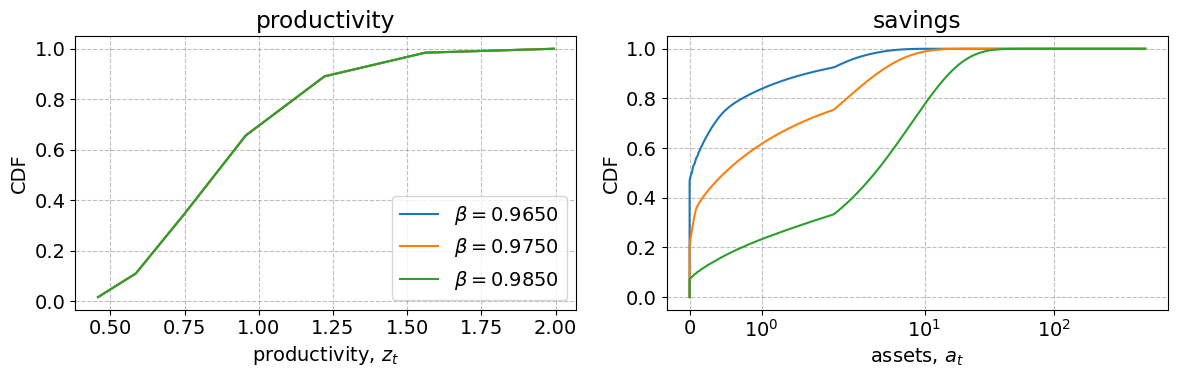

In [24]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')
for i_beta,beta in enumerate(par.beta_grid):
    ax.plot(par.z_grid,np.cumsum(np.sum(ss.D[i_beta],axis=1))*par.Nfix,label=f'$\\beta = {beta:.4f}$')

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend()

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
for i_beta in range(par.Nfix):
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(ss.D[i_beta],axis=0)),0,0.0)*par.Nfix,label=f'$\\beta = {par.beta_grid[i_beta]:.4f}$')
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

fig.tight_layout()
fig.savefig('figs/distribution.pdf')

**Income moments:**

In [25]:
mean_z = np.sum(ss.D*par.z_grid[:,np.newaxis])
std_z = np.sqrt(np.sum(ss.D*(par.z_grid[np.newaxis,:,np.newaxis]-mean_z)**2))
print(f'mean z: {mean_z:5.2f}')
print(f'std. z: {std_z:5.2f}')

mean z:  1.00
std. z:  0.30


**Asset moments:**

In [26]:
# a. prepare
Da = np.sum(ss.D,axis=(0,1))
Da_cs = np.cumsum(Da)
mean_a = np.sum(Da*par.a_grid)
std_a = np.sqrt(np.sum(Da*(par.a_grid-mean_a)**2))

def percentile(par,Da_cs,p):
    
    # a. check first
    if p < Da_cs[0]: return par.a_grid[0]
    
    # b. find with loop
    i = 0
    while True:
        if p > Da_cs[i+1]:
            if i+1 >= par.Na: raise Exception()
            i += 1
            continue
        else:
            w = (p-Da_cs[i])/(Da_cs[i+1]-Da_cs[i])
            diff = par.a_grid[i+1]-par.a_grid[i]
            return par.a_grid[i]+w*diff
        
p25_a = percentile(par,Da_cs,0.25)
p50_a = percentile(par,Da_cs,0.50)
p95_a = percentile(par,Da_cs,0.95)
p99_a = percentile(par,Da_cs,0.99)

# b. print
print(f'mean a: {mean_a:6.3f}')
print(f'p25  a: {p25_a:6.3f}')
print(f'p50  a: {p50_a:6.3f}')
print(f'p95  a: {p95_a:6.3f}')
print(f'p99  a: {p99_a:6.3f}')
print(f'std. a: {std_a:6.3f}')

mean a:  2.775
p25  a:  0.001
p50  a:  0.616
p95  a: 12.911
p99  a: 23.004
std. a:  4.898


**MPC:**

In [ ]:
# warning: this might be imprecise if the number of grid points for a is not very large

def calc_MPC(par,ss):
    
    MPC = np.zeros(ss.D.shape)
    dc = (ss.c[:,:,1:]-ss.c[:,:,:-1])
    dm = (1+model.ss.r)*(par.a_grid[np.newaxis,np.newaxis,1:]-par.a_grid[np.newaxis,np.newaxis,:-1])
    MPC[:,:,:-1] = dc/dm
    MPC[:,:,-1] = MPC[:,:,-2] # assuming constant MPC at end
    mean_MPC = np.sum(MPC*ss.D)
    
    return mean_MPC

mean_MPC = calc_MPC(par,ss)
print(f'mean MPC: {mean_MPC:.3f}')

mean MPC: 0.269


## 4. <a id='toc4_'></a>[Some analysis](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Demand vs. supply of capital](#toc0_)

r_ss =  0.0070
K_firm_demand =  2.8406
w_ss =  1.0084
household problem in ss solved in 1.1 secs [970 iterations]
household problem in ss simulated in 0.3 secs [875 iterations]
K_hh_supply =  1.7028
clearing_A = -1.1377

r_ss =  0.0080
K_firm_demand =  2.8185
w_ss =  1.0056
household problem in ss solved in 1.5 secs [1059 iterations]
household problem in ss simulated in 0.5 secs [1005 iterations]
K_hh_supply =  1.9735
clearing_A = -0.8450

r_ss =  0.0090
K_firm_demand =  2.7967
w_ss =  1.0028
household problem in ss solved in 1.3 secs [1166 iterations]
household problem in ss simulated in 0.4 secs [1181 iterations]
K_hh_supply =  2.3182
clearing_A = -0.4785

r_ss =  0.0100
K_firm_demand =  2.7751
w_ss =  1.0000
household problem in ss solved in 1.9 secs [1287 iterations]
household problem in ss simulated in 0.7 secs [1438 iterations]
K_hh_supply =  2.7751
clearing_A =  0.0000

r_ss =  0.0110
K_firm_demand =  2.7539
w_ss =  0.9972
household problem in ss solved in 1.2 secs [1431 iterati

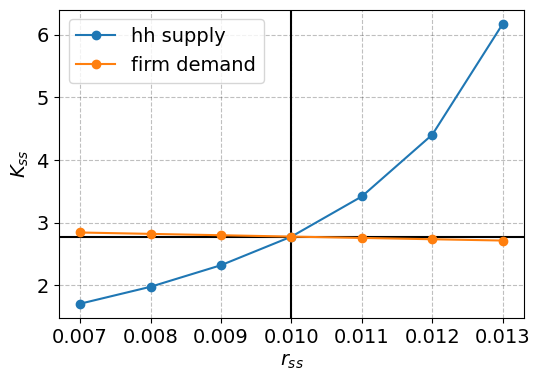

In [28]:
# allocate
Nr_ss = 7
r_ss_min = 0.007
r_ss_max = 0.013
r_ss_vec = np.linspace(r_ss_min,r_ss_max,Nr_ss)

K_hh_supply = np.zeros(Nr_ss)
K_firm_demand = np.zeros(Nr_ss)

# calculate
for i,r_ss in enumerate(r_ss_vec):
    
    print(f'{r_ss = :7.4f}')
          
    model_ = model.copy()
    model_.ss.r = r_ss
    
    # a. firms
    K_firm_demand[i] = ((r_ss+par.delta)/(par.alpha*ss.Gamma))**(1/(par.alpha-1))
    print(f'K_firm_demand = {K_firm_demand[i]:7.4f}')
    
    w_ss = model_.ss.w = (1.0-par.alpha)*ss.Gamma*(K_firm_demand[i]/ss.L)**par.alpha

    print(f'{w_ss = :7.4f}')

    # b. households
    model_.solve_hh_ss(do_print=True)
    model_.simulate_hh_ss(do_print=True)
    
    K_hh_supply[i] = np.sum(model_.ss.a*model_.ss.D)
    print(f'K_hh_supply = {K_hh_supply[i]:7.4f}')
          
    # c. clearing
    clearing_A = K_hh_supply[i]-K_firm_demand[i]
    print(f'{clearing_A = :7.4f}\n')
    
# plot
fig = plt.figure(figsize=(6,6/1.5),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.axvline(ss.r,color='black')
ax.axhline(ss.K,color='black')

ax.plot(r_ss_vec,K_hh_supply,'-o',label='hh supply')
ax.plot(r_ss_vec,K_firm_demand,'-o',label='firm demand')

ax.set_xlabel('$r_{ss}$')
ax.set_ylabel('$K_{ss}$')
ax.legend(frameon=True);    

### 4.2. <a id='toc4_2_'></a>[Idiosyncratic risk and the steady state interest rate](#toc0_)

What happens to saving when income risk increases?

In [29]:
print(f'ss.A_hh = ss.K = {ss.A_hh:.2f}')
print(f'ss.r = {ss.r*100:.2f} %')
print('')
      
for sigma_psi in np.linspace(par.sigma_psi,2*par.sigma_psi,5):
    
    print(f'{sigma_psi = :.2f}')

    model_ = model.copy()
    model_.par.sigma_psi = sigma_psi
        
    model_.solve_hh_ss(do_print=False)
    model_.simulate_hh_ss(do_print=False)
    
    A_hh = np.sum(model_.ss.a*model_.ss.D)
    
    print(f'PE {A_hh = :.2f}')
          
    model_.find_ss(method='direct')

    print(f'GE ss.r = {model_.ss.r*100:.2f} %')
    print(f'GE ss.A_hh = ss.K = {model_.ss.A_hh:.2f}')

    print('')

ss.A_hh = ss.K = 2.78
ss.r = 1.00 %

sigma_psi = 0.09
PE A_hh = 2.78
GE ss.r = 1.00 %
GE ss.A_hh = ss.K = 2.78

sigma_psi = 0.12
PE A_hh = 4.83
GE ss.r = 0.62 %
GE ss.A_hh = ss.K = 2.86

sigma_psi = 0.14
PE A_hh = 7.39
GE ss.r = 0.12 %
GE ss.A_hh = ss.K = 2.97

sigma_psi = 0.16
PE A_hh = 10.37
GE ss.r = -0.46 %
GE ss.A_hh = ss.K = 3.12

sigma_psi = 0.19
PE A_hh = 13.68
GE ss.r = -1.11 %
GE ss.A_hh = ss.K = 3.30



### 4.3. <a id='toc4_3_'></a>[Calibration](#toc0_)

Choose `beta_mean` to get chosen average MPC.

In [30]:
from root_finding import brentq

In [31]:
def calib_obj(beta_mean,model):
    """ calibration objective """
    
    model.par.beta_mean = beta_mean
    model.find_ss(method='direct')    
    
    mean_MPC = calc_MPC(model.par,model.ss)
    
    return mean_MPC-0.27

In [32]:
model_calib = model.copy()
brentq(calib_obj,par.beta_mean-0.01,par.beta_mean,args=(model_calib,),do_print=True,varname='beta_mean',funcname='MPC-0.27',xtol=1e-8,rtol=1e-8);

  0: beta_mean =   0.97443905 -> MPC-0.27 =   0.00007915
  1: beta_mean =   0.97447952 -> MPC-0.27 =   0.00000034
  2: beta_mean =   0.97447970 -> MPC-0.27 =  -0.00000000
  3: beta_mean =   0.97447969 -> MPC-0.27 =   0.00000002

beta_mean =   0.97447970 [MPC-0.27 =  -0.00000000]



In [33]:
print(f'ss.r = {model_calib.ss.r*100:.2f} %')
print(f'ss.K = {model_calib.ss.K:.2f}')

ss.r = 1.05 %
ss.K = 2.76


**Question:** What could an alternative be to use a root-finder?

### 4.4. <a id='toc4_4_'></a>[Drivers of wealth inequality](#toc0_)

In [34]:
model_ = model.copy()
model_.par.Nphi = 3
model_.par.phi_delta = 0.50
model_.allocate() # to account for new dimensions
model_.find_ss(method='indirect')

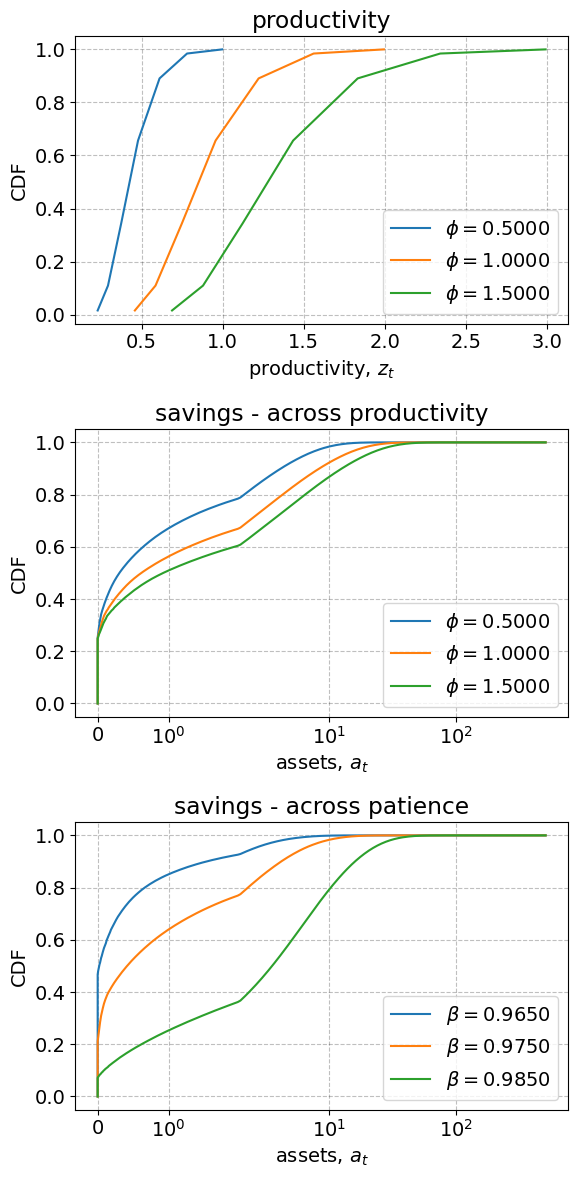

In [35]:
fig = plt.figure(figsize=(6,12),dpi=100)

D = model_.ss.D
phi_grid = model_.par.phi_grid
beta_grid = model_.par.beta_grid

# a. income
ax = fig.add_subplot(3,1,1)
ax.set_title('productivity')
for i_phi,phi in enumerate(np.unique(phi_grid)):

    I = phi_grid == phi
    y = np.array([np.sum(np.sum(D[I,i_z,:])) for i_z in range(par.Nz)])
    ax.plot(phi*par.z_grid,np.cumsum(y)*par.Nfix,label=f'$\\phi = {phi:.4f}$')

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')
ax.legend()

# b. assets
ax = fig.add_subplot(3,1,2)
ax.set_title('savings - across productivity')
for i_phi,phi in enumerate(np.unique(phi_grid)):

    I = phi_grid == phi
    y = np.array([np.sum(D[I,:,i_a]) for i_a in range(par.Na)])
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(y),0,0.0)*par.Nfix,label=f'$\\phi = {phi:.4f}$')

ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend()

# b. assets
ax = fig.add_subplot(3,1,3)
ax.set_title('savings - across patience')
for i_beta,beta in enumerate(np.unique(beta_grid)):

    I = beta_grid == beta
    y = np.array([np.sum(D[I,:,i_a]) for i_a in range(par.Na)])
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(y),0,0.0)*par.Nfix,label=f'$\\beta = {beta:.4f}$')

ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')
ax.legend()


fig.tight_layout()
fig.savefig('figs/distribution_with_ability.pdf')

## 5. <a id='toc5_'></a>[Tests](#toc0_)

Here we run a couple of tests to show that the code behaves as expected. This is especially valuable when developing a new model.

**Steady state:**

Check that there are no nan values in `.ss`

In [36]:
model.test_ss(do_warnings=True)

Gamma          :       1.0820
K              :       2.7751
L              :       1.0000
rK             :       0.2027
w              :       1.0000
Y              :       1.5625
A              :       2.7751
r              :       0.0100
A_hh           :       2.7751
C_hh           :       1.0278
L_hh           :       1.0000
I              :       0.5347
clearing_A     :      -0.0000
clearing_L     :       0.0000
clearing_Y     :       0.0000


**Household transition path:**

Check that the household policy functions and distribtuion have properly converged. 
Otherwise solving backwards and simulating forwards with aggregate variables at their steady state would imply a sizeable divergence from steady state in household outcomes, roughly larger than $10^{-5}$.

note: inputs = steady state value -> expected: constant value (straigt line) in roughly -10^-5 to 10^5

household problem solved along transition path in 1.8 secs
household problem simulated along transition in 3.3 secs



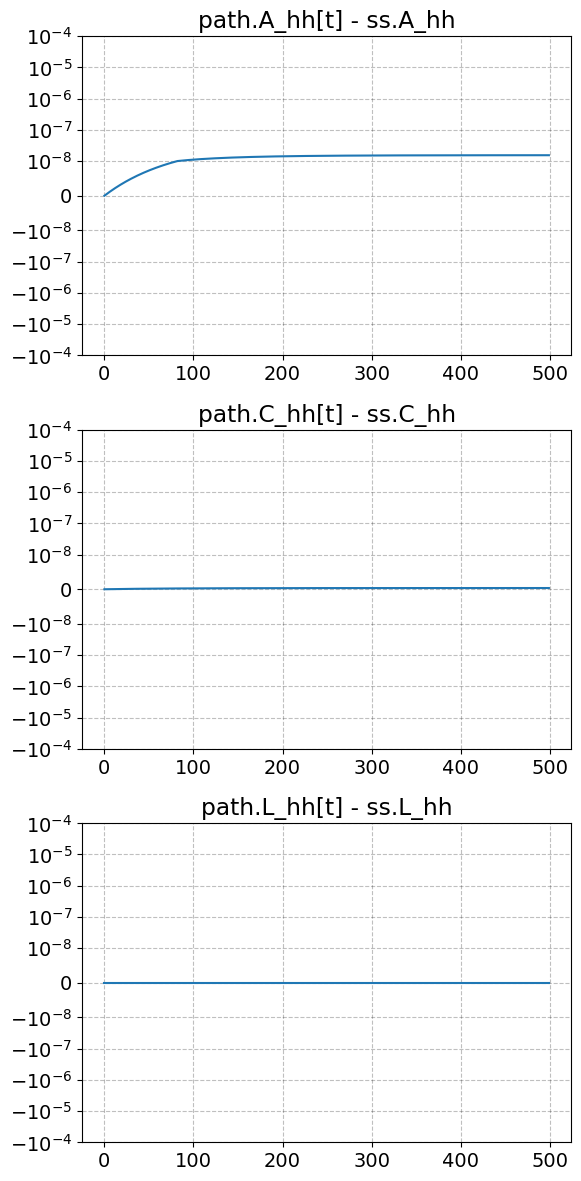

In [37]:
model.test_hh_path()

**Full transition path:**

Check that setting shocks and unknowns to their steady state values implies all other variables are at the steady state values, and that the target equations are zero.

In [38]:
model.test_path()

shocks: Gamma 
unknowns: K L 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production_firm
  rK               0.0e+00
  w                0.0e+00
  Y                0.0e+00
 blocks.mutual_fund
  A                0.0e+00
  r                0.0e+00
 hh
  A_hh             1.5e-08
  C_hh             3.5e-10
  L_hh             2.8e-15
 blocks.market_clearing
  I                3.3e-16
  clearing_A       1.5e-08 [target]
  clearing_L       1.9e-14 [target]
  clearing_Y       3.5e-10


**Calculation of Jacobians:**

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 2.0 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 1.4 secs]
finding Jacobian wrt. w              : 0 125 250 375 [computed in 2.2 secs]
household Jacobian computed in 5.8 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.8 secs
curly_Y and curly_D calculated for w               in 0.8 secs
curly_E calculated in 3.1 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 5.2 secs

full Jacobian to unknowns computed in 0.6 secs [in evaluate_blocks(): 0.2 secs]
full Jacobian to shocks computed in 0.4 secs [in evaluate_blocks(): 0.1 secs]


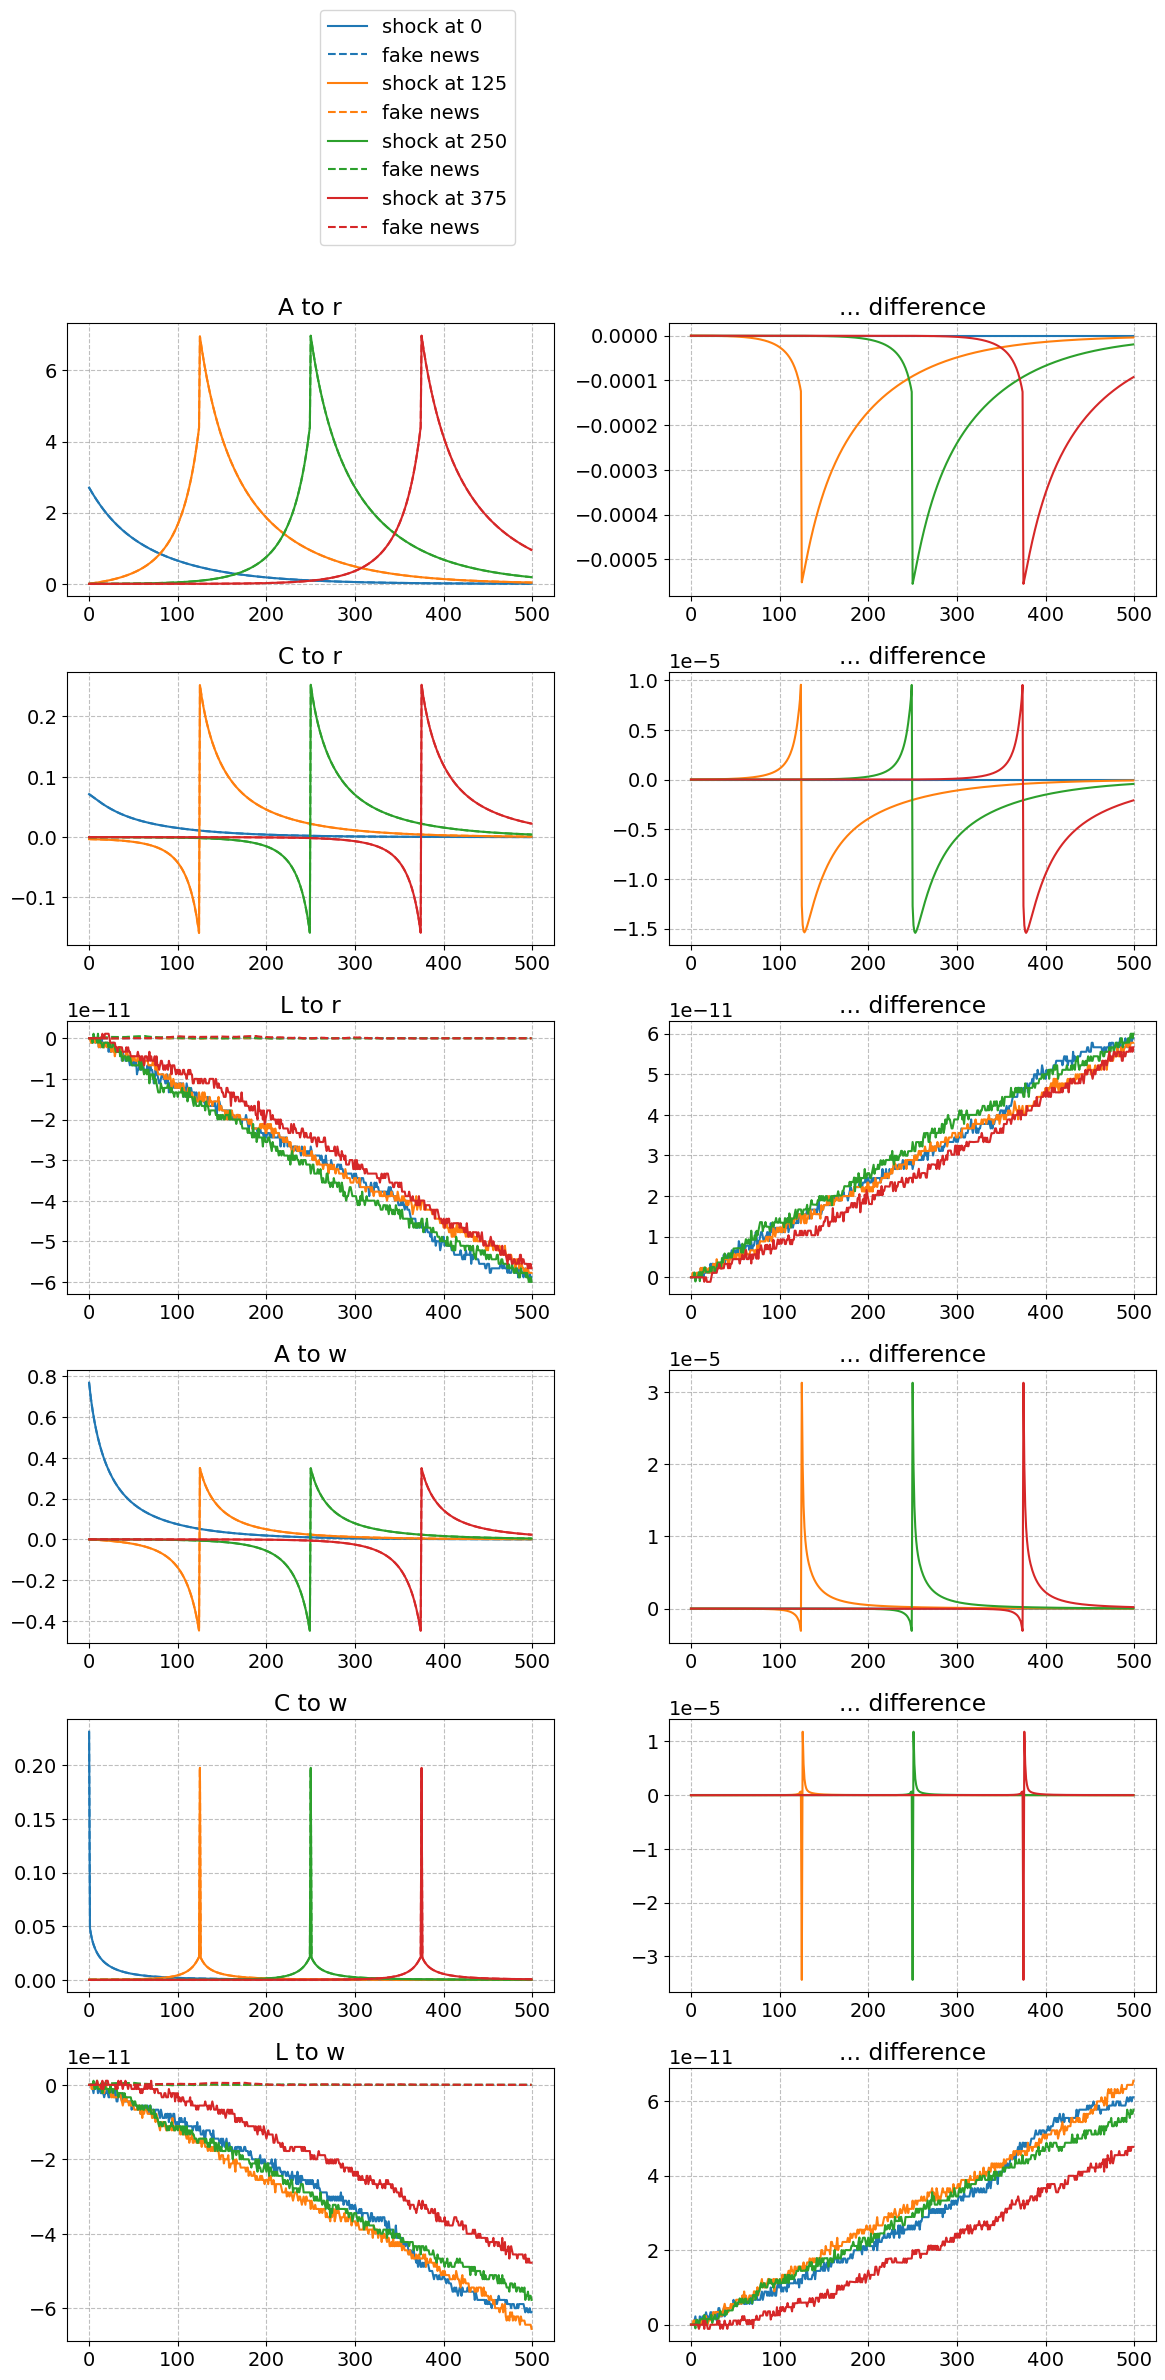

In [39]:
model.test_jacs()

## 6. <a id='toc6_'></a>[Step 2: Compute Jacobians](#toc0_)

In [40]:
model.compute_jacs(do_print=True) # if skip_shocks = True the full Jacobians to shocks are  not computed

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for r               in 0.8 secs
curly_Y and curly_D calculated for w               in 0.8 secs
curly_E calculated in 0.9 secs
builiding blocks combined in 0.4 secs
household Jacobian computed in 3.0 secs

full Jacobians:
full Jacobian to unknowns computed in 0.8 secs [in evaluate_blocks(): 0.3 secs]
full Jacobian to shocks computed in 0.4 secs [in evaluate_blocks(): 0.1 secs]


The Jacobians are saved in:

1. **household Jacobians**: `model.jac_hh` is a dictionary with keys `(Outputname_hh,inputname)`
1. **full Jacobian to *unknowns***: `model.H_U` is a matrix
1. **full Jacobian to *shocks***: `model.H_Z` is a matrix
1. **full Jacobians**: `model.jac` is a dictionary with keys `(outputname,inputname)`

The **household Jacobians** are e.g. informative to look at.

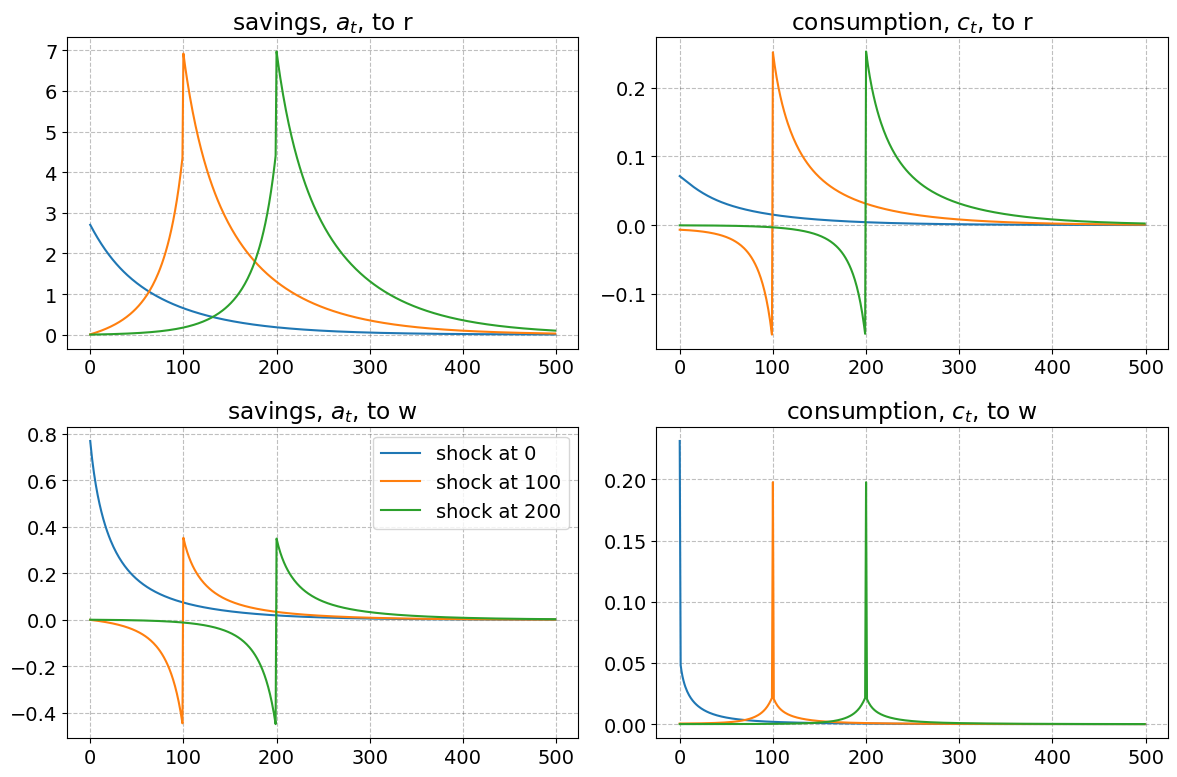

In [41]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

    if i == 3: ax.legend(frameon=True)

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,100,200]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')

fig.tight_layout()
fig.savefig('figs/jac_hh.pdf')

## 7. <a id='toc7_'></a>[Step 3a: Find non-linear transition_path](#toc0_)

Compute a transition to a technology shock where the jump is `par.jump_Gamma` and the AR(1) coefficient is `par.rho_Gamma`.

In [42]:
model.find_transition_path(shocks=['Gamma'],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 7.53e-01
   7.53e-01 in clearing_A
   2.51e-14 in clearing_L
 it =   1 -> max. abs. error = 8.27e-02
   8.27e-02 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 9.59e-03
   9.59e-03 in clearing_A
   3.33e-16 in clearing_L
 it =   3 -> max. abs. error = 1.62e-04
   1.62e-04 in clearing_A
   7.77e-16 in clearing_L
 it =   4 -> max. abs. error = 8.25e-06
   8.25e-06 in clearing_A
   3.33e-16 in clearing_L
 it =   5 -> max. abs. error = 9.17e-08
   9.17e-08 in clearing_A
   6.66e-16 in clearing_L
 it =   6 -> max. abs. error = 1.21e-10
   1.21e-10 in clearing_A
   5.55e-16 in clearing_L
 it =   7 -> max. abs. error = 2.54e-12
   2.54e-12 in clearing_A
   6.66e-16 in clearing_L

transition path found in 7.5 secs


**Results:** We now have

1. The transition path of all variables, `path.VARNAME.shape == (par.T,1)`
1. The transition path of policy functions, `path.a` and `path.c`
1. The transition path of distributions, `path.D`

The **timing** is such that `path.A_hh[t] == np.sum(path.a[t]*path.D[t])`.

In [43]:
diff = path.A_hh-np.sum(path.a*path.D,axis=(1,2,3))[:,np.newaxis]
max_abs_diff = np.max(np.abs(diff))
print(f'{max_abs_diff = }')

max_abs_diff = 0.0


**Plot transitions**

### shocks ###


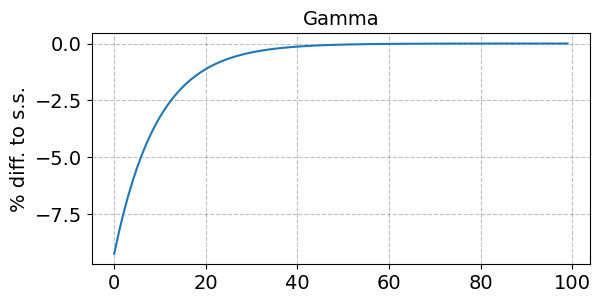


### varnames ###


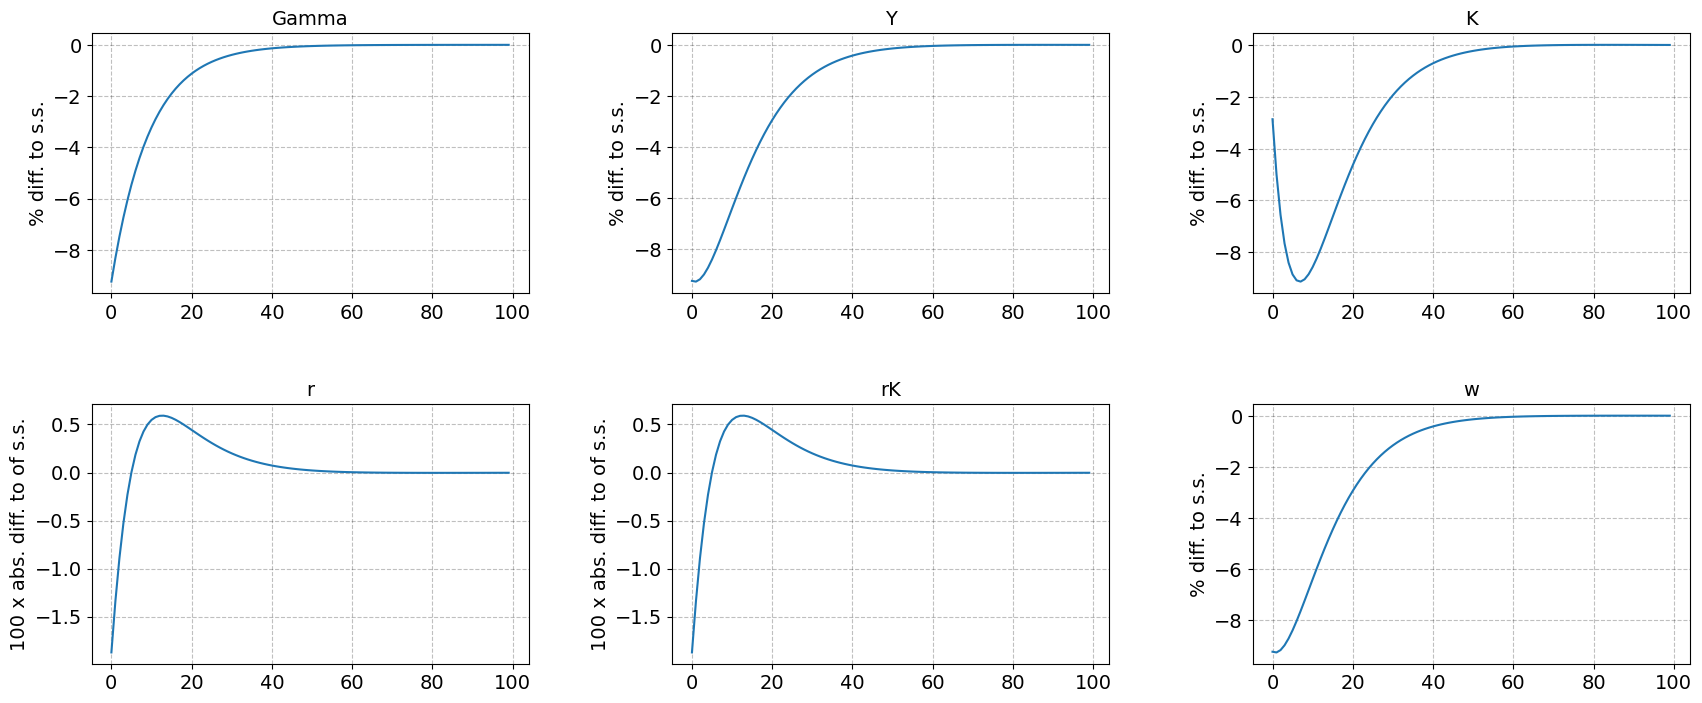


### tagets ###


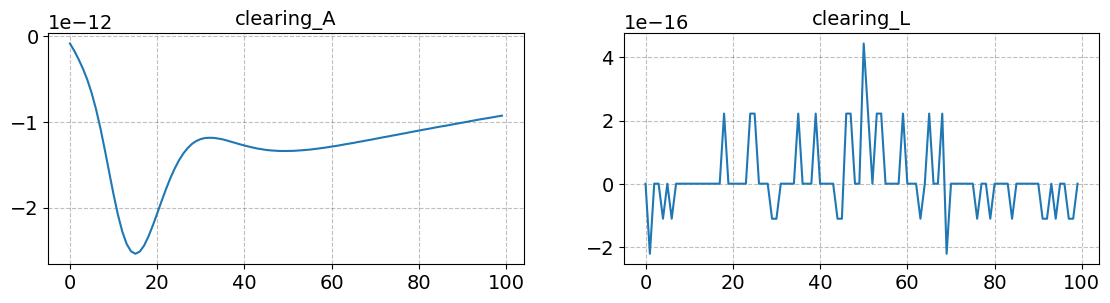

In [44]:
paths = ['Gamma','Y','K','r','rK','w']
abs_diff = ['r','rK']
facs = {'r':100,'rK':100}
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,filename='figs/technology_shock')

**Manual transition path plot:**

<>:8: SyntaxWarning: invalid escape sequence '\G'
<>:8: SyntaxWarning: invalid escape sequence '\G'
C:\Users\gmf123\AppData\Local\Temp\ipykernel_20984\1980228245.py:8: SyntaxWarning: invalid escape sequence '\G'
  ax.set_title('technology shock, $\Gamma_t$')


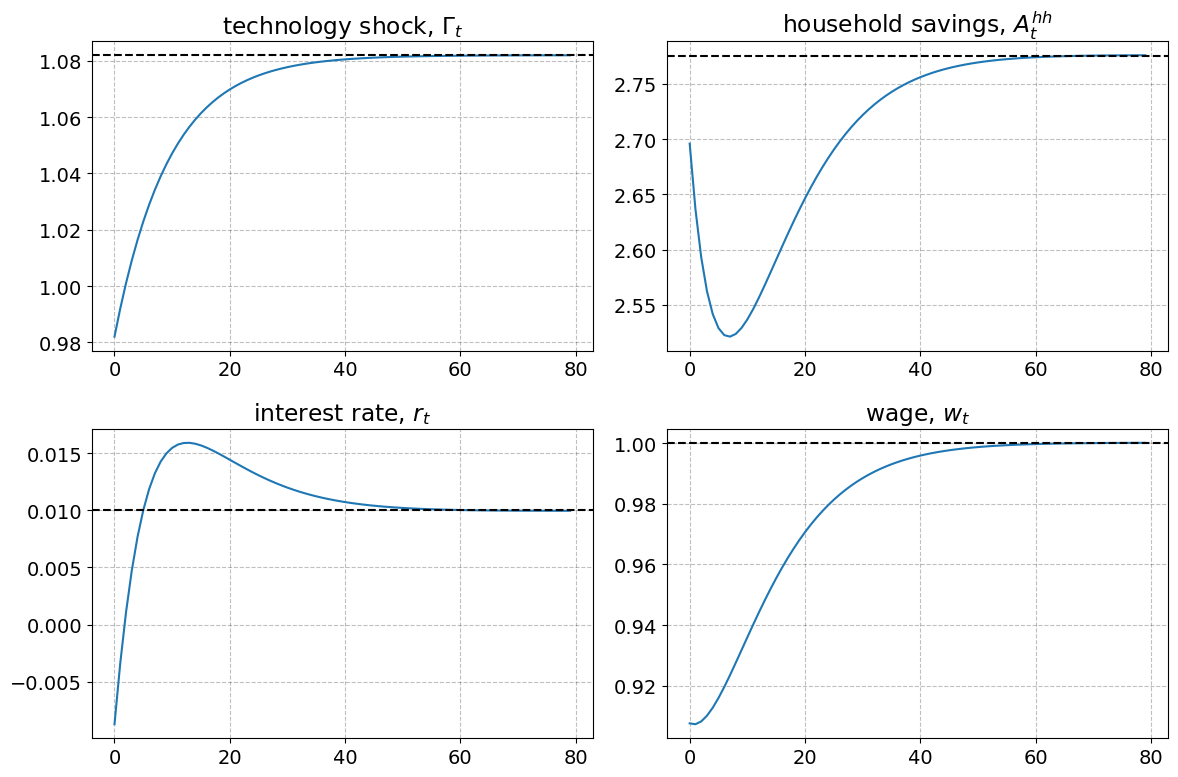

In [45]:
T_max = 80

fig = plt.figure(figsize=(12,2*4),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(T_max),path.Gamma[:T_max])
ax.axhline(ss.Gamma,color='black',linestyle='--')
ax.set_title('technology shock, $\Gamma_t$')

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(T_max),path.A_hh[:T_max])
ax.axhline(ss.A_hh,color='black',linestyle='--')
ax.set_title('household savings, $A^{hh}_t$')

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(T_max),path.r[:T_max])
ax.axhline(ss.r,color='black',linestyle='--')
ax.set_title('interest rate, $r_t$')

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(T_max),path.w[:T_max])
ax.axhline(ss.w,color='black',linestyle='--')
ax.set_title('wage, $w_t$')

fig.tight_layout()
fig.savefig('figs/transition_path.pdf')

**How does the consumption function change over time?**

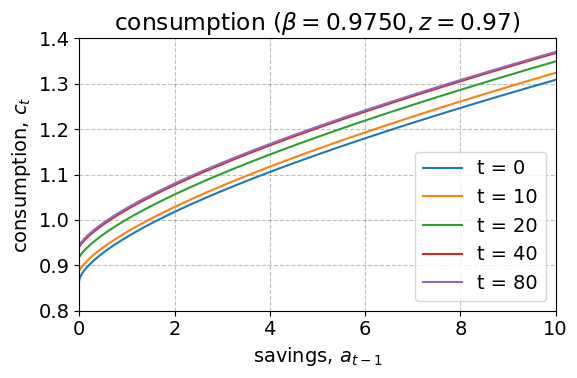

In [46]:
i_beta = 1
i_z = par.Nz//2
beta = par.beta_grid[i_beta]
z = par.z_grid[i_z]

fig = plt.figure(figsize=(6,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,1,1)
ax.set_title(f'consumption ($\\beta = {beta:.4f}, z = {beta:.2f}$)')

ts = [0,10,20,40,80]
for t in ts:
    ax.plot(par.a_grid[I],path.c[t,i_beta,i_z,I],label=f'{t = }')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')
ax.set_xlim(0,10)
ax.set_ylim(0.8,1.4)

fig.tight_layout()
fig.savefig('figs/c_func_path.pdf')

**How does the distribution change over time?**

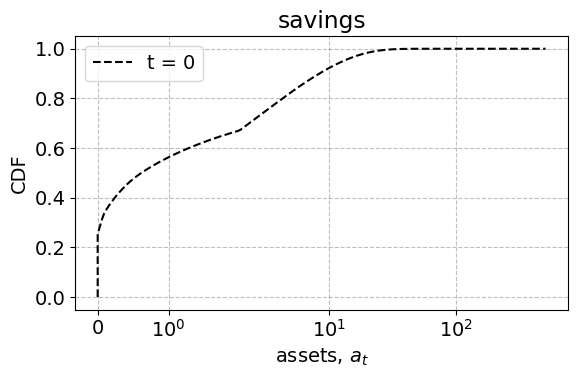

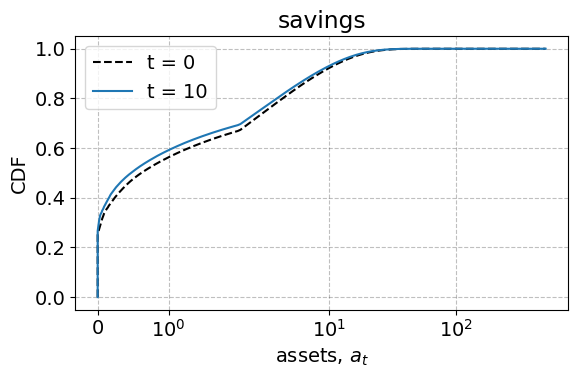

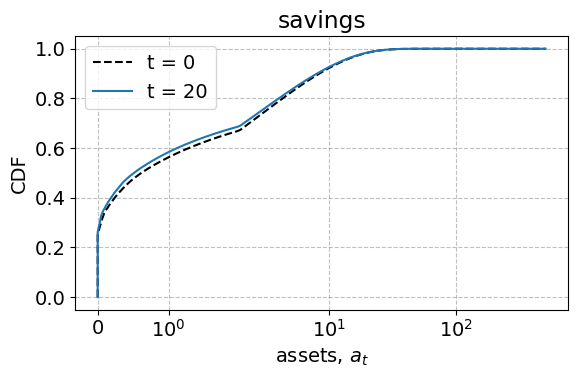

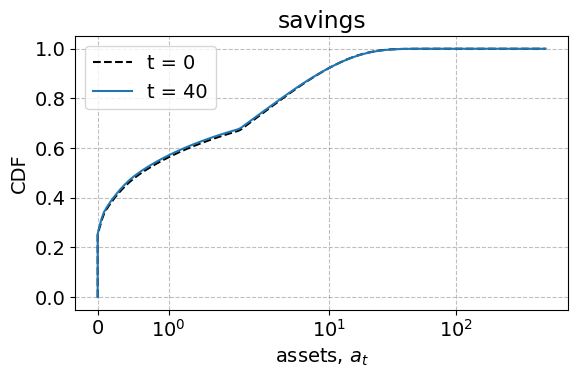

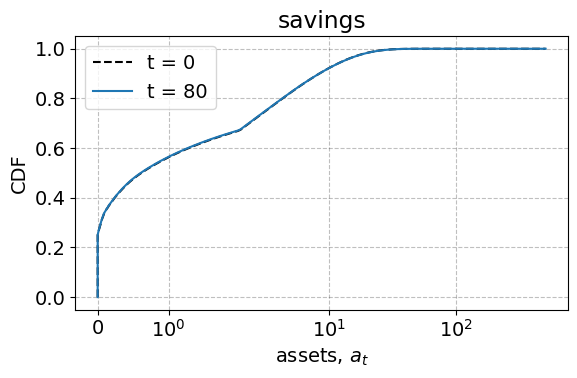

In [47]:
for t in ts:

    fig = plt.figure(figsize=(6,4),dpi=100)

    ax = fig.add_subplot(1,1,1)
    ax.set_title('savings')    

    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[0],axis=(0,1))),0,0.0),label=f't = 0',ls='--',color='black')
    
    if not t == 0:
        ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),np.insert(np.cumsum(np.sum(path.D[t],axis=(0,1))),0,0.0),label=f't = {t}')

    ax.set_xlabel('assets, $a_{t}$')
    ax.set_ylabel('CDF')
    ax.set_xscale('symlog')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'figs/distribution_path_{t}.pdf')

## 8. <a id='toc8_'></a>[Step 3b: Find linearized IRFs](#toc0_)

In [48]:
model.find_IRFs(shocks=['Gamma'],do_print=True,reuse_G_U=False)

linear transition path found in 0.0 secs [finding solution matrix: 0.0 secs]


**Results:** We now have `model.IRF[varname]` with the linear impulse response of all variables.

### shocks ###


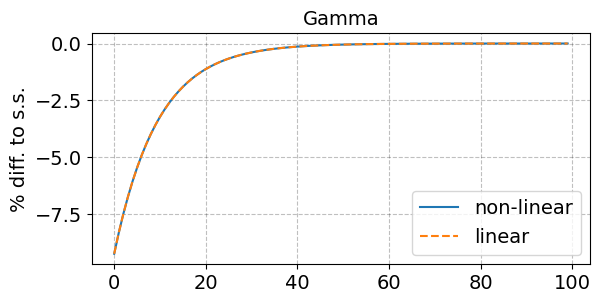


### varnames ###


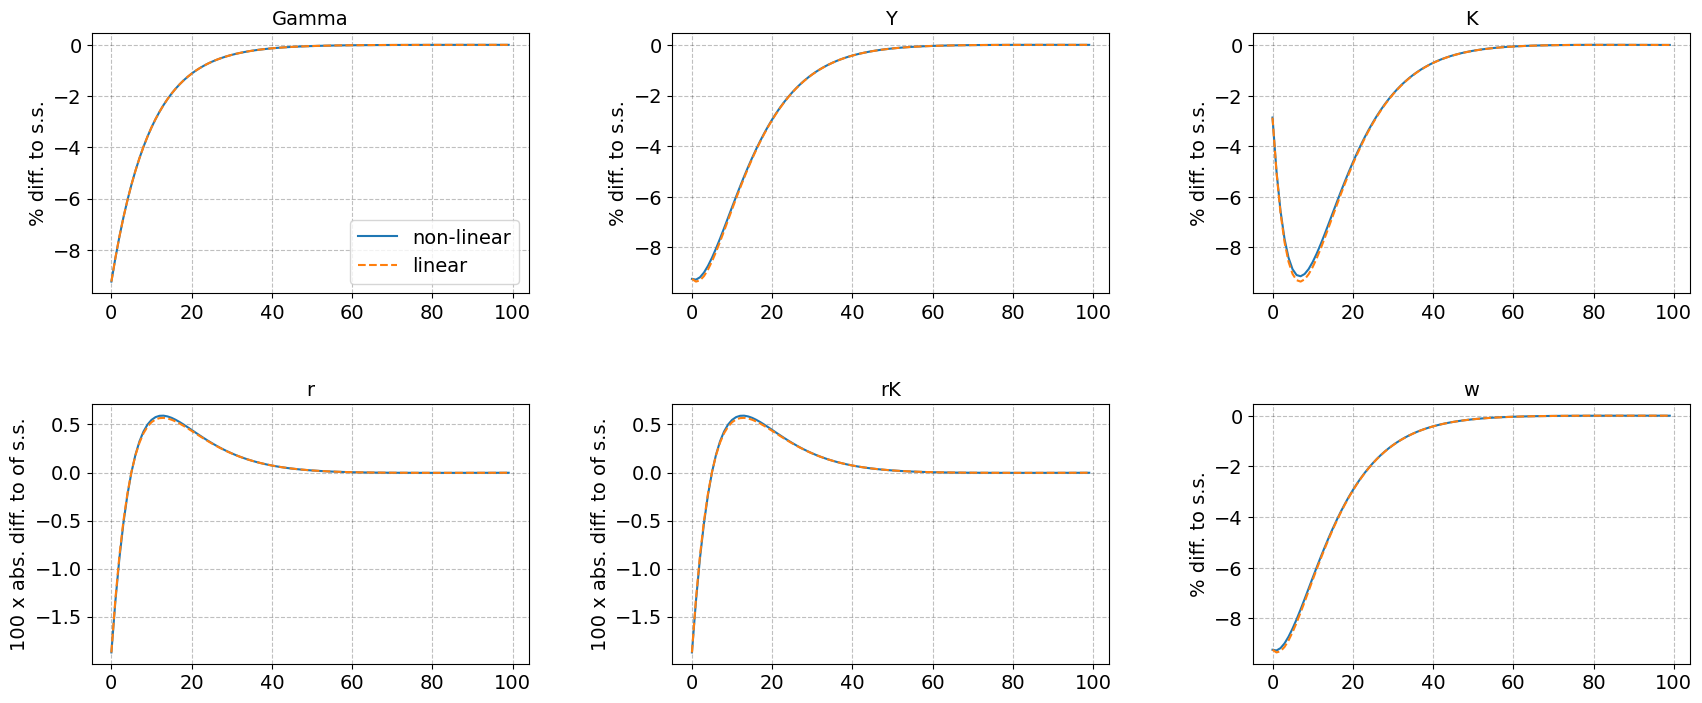


### tagets ###


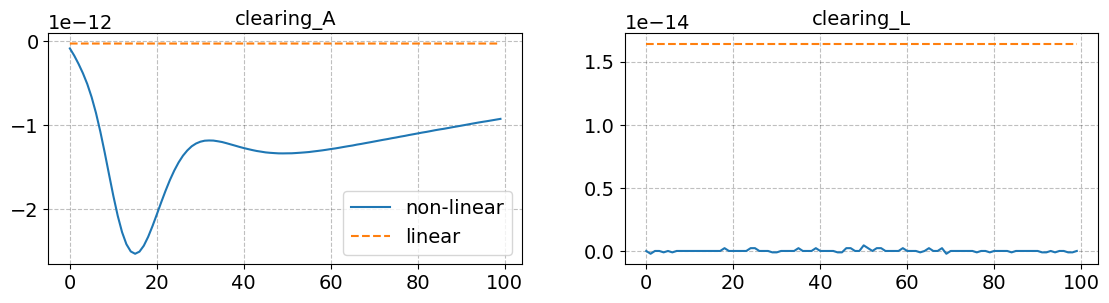

In [49]:
model.show_IRFs(paths,abs_diff=abs_diff,facs=facs,ncols=3,T_max=100,do_linear=True)

## 9. <a id='toc9_'></a>[Decompose household behavior](#toc0_)

Find behavior when only some household inputs are active.

['r']
household problem solved along transition path in 0.6 secs
household problem simulated along transition in 0.2 secs

['w']
household problem solved along transition path in 0.6 secs
household problem simulated along transition in 0.2 secs

None
household problem solved along transition path in 0.7 secs
household problem simulated along transition in 0.2 secs

all
household problem solved along transition path in 0.6 secs
household problem simulated along transition in 0.3 secs



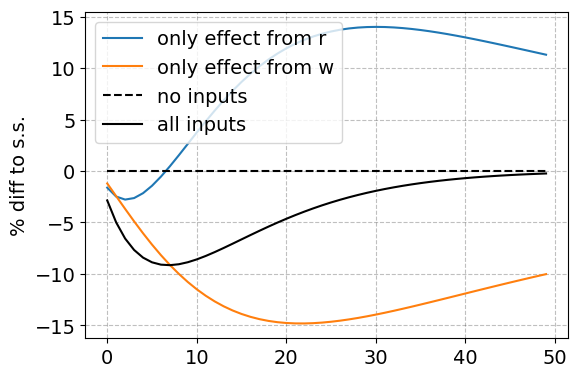

In [50]:
T_max = 50

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
    
i_color = 0
for use_inputs in [['r'],['w'],None,'all']:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);

ax.set_ylabel('% diff to s.s.')
ax.legend(frameon=True)

fig.tight_layout()
fig.savefig('figs/decomposition.pdf')

**Case 2:** Behavior for a subset of households. Here those with zero assets.

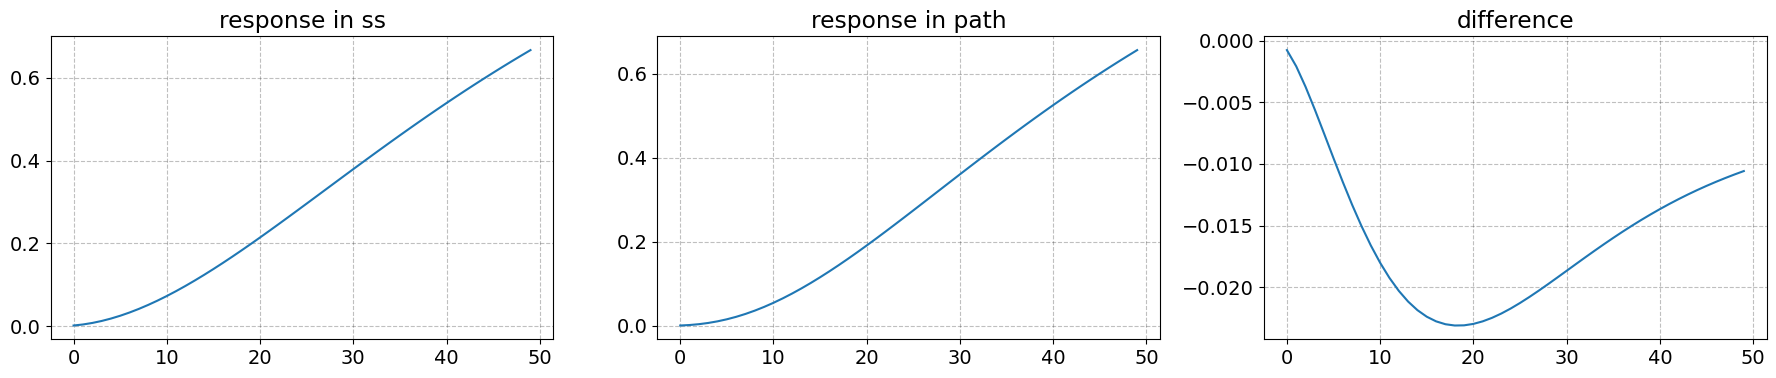

In [51]:
T_max = 50

fig = plt.figure(figsize=(3*6,4),dpi=100)
    
Dbeg = ss.Dbeg.copy()
Dbeg[:,:,1:] = 0.0 # zero every else than in first asset grid point
Dbeg /= np.sum(Dbeg) # re-normalize

path_alt_ss = model.decompose_hh_path(Dbeg=Dbeg,use_inputs=None)    
path_alt = model.decompose_hh_path(Dbeg=Dbeg,use_inputs='all') 

ax = fig.add_subplot(1,3,1)
ax.set_title('response in ss')
ax.plot(path_alt_ss.A_hh[:T_max]);

ax = fig.add_subplot(1,3,2)
ax.set_title('response in path')
ax.plot(path_alt.A_hh[:T_max]);

ax = fig.add_subplot(1,3,3)
ax.set_title('difference')
ax.plot(path_alt.A_hh[:T_max]-path_alt_ss.A_hh[:T_max])

fig.tight_layout()

## 10. <a id='toc10_'></a>[Custom shocks](#toc0_)

### 10.1. <a id='toc10_1_'></a>[Path](#toc0_)

In [52]:
# a. define shock
dGamma = np.zeros(par.T)
dGamma[12:24] = 0.01*ss.Gamma
shocks = {'dGamma':dGamma} # note the 'd' for difference (in absolute terms)

# b. find transition path
model.find_transition_path(do_print=True,shocks=shocks)

finding the transition path:
 it =   0 -> max. abs. error = 1.65e-01
   1.65e-01 in clearing_A
   2.55e-14 in clearing_L
 it =   1 -> max. abs. error = 2.45e-03
   2.45e-03 in clearing_A
   6.66e-16 in clearing_L
 it =   2 -> max. abs. error = 5.97e-05
   5.97e-05 in clearing_A
   4.44e-16 in clearing_L
 it =   3 -> max. abs. error = 2.77e-07
   2.77e-07 in clearing_A
   4.44e-16 in clearing_L
 it =   4 -> max. abs. error = 2.74e-09
   2.74e-09 in clearing_A
   3.33e-16 in clearing_L
 it =   5 -> max. abs. error = 6.95e-12
   6.95e-12 in clearing_A
   5.55e-16 in clearing_L

transition path found in 4.9 secs


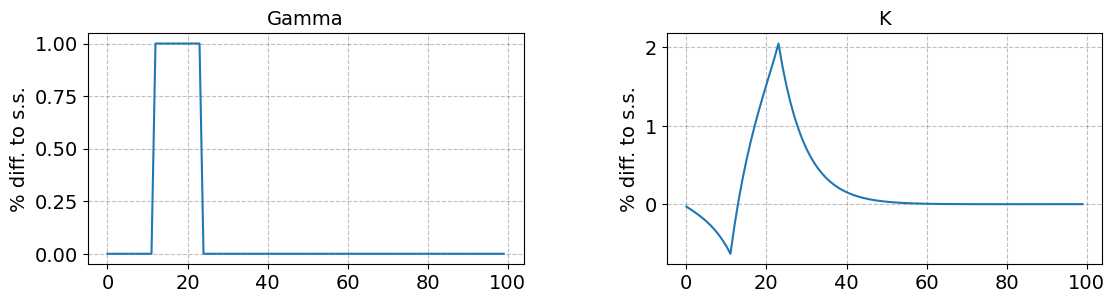

In [53]:
model.show_IRFs(['Gamma','K'],T_max=100,do_shocks=False,do_targets=False,ncols=2,filename='figs/future_technology_shock')

### 10.2. <a id='toc10_2_'></a>[Initial distribution](#toc0_)

**Shock:** Assume everybody looses 5 percent of their wealth.

In [54]:
K_shock = -0.05

**Adjust distribution:**

In [55]:
ini = {}
ini['Dbeg'] = np.zeros(ss.Dbeg.shape)
for i_a_lag in range(par.Na):
    
    # a. assets after shock
    a_lag = par.a_grid[i_a_lag]
    a_lag_after = a_lag*(1+K_shock)
    
    # b. new grid point
    for i in range(par.Na-1):
        if not par.a_grid[i+1] <= a_lag_after: break
    
    # c. distribute mass
    w = (par.a_grid[i+1]-a_lag_after)/(par.a_grid[i+1]-par.a_grid[i])
    
    for i_fix in range(par.Nfix):
        ini['Dbeg'][i_fix,:,i] += w*ss.Dbeg[i_fix,:,i_a_lag]
        ini['Dbeg'][i_fix,:,i+1] += (1-w)*ss.Dbeg[i_fix,:,i_a_lag]    
    

**Calculate new capital stock:**

In [56]:
ini_K = ini['K'] = np.sum(par.a_grid*ini['Dbeg'])
print(f'{ss.K  = :.3f}')
print(f'{ini_K = :.3f}')

ss.K  = 2.775
ini_K = 2.636


**Find transition with no shocks:**

In [57]:
model.find_transition_path(do_print=True,ini=ini,shocks=[]) 

finding the transition path:
 it =   0 -> max. abs. error = 1.33e-01
   1.33e-01 in clearing_A
   2.48e-14 in clearing_L
 it =   1 -> max. abs. error = 7.77e-04
   7.77e-04 in clearing_A
   4.44e-16 in clearing_L
 it =   2 -> max. abs. error = 1.12e-05
   1.12e-05 in clearing_A
   6.66e-16 in clearing_L
 it =   3 -> max. abs. error = 3.02e-08
   3.02e-08 in clearing_A
   4.44e-16 in clearing_L
 it =   4 -> max. abs. error = 2.31e-10
   2.31e-10 in clearing_A
   7.77e-16 in clearing_L
 it =   5 -> max. abs. error = 1.18e-13
   1.18e-13 in clearing_A
   3.33e-16 in clearing_L

transition path found in 4.7 secs


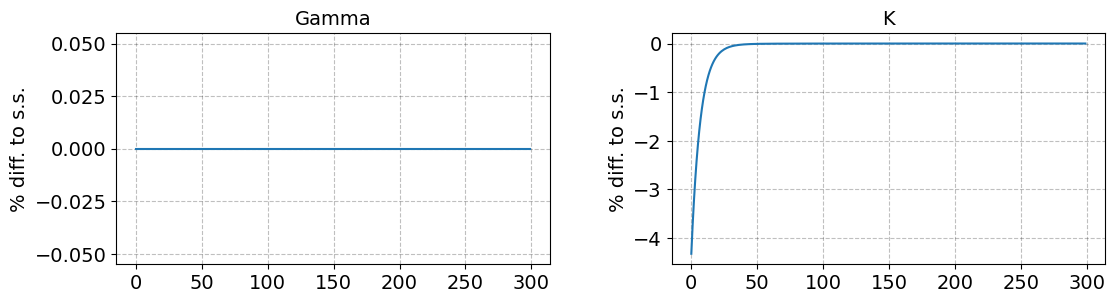

In [58]:
model.show_IRFs(['Gamma','K'],T_max=300,do_shocks=False,do_targets=False,ncols=2,filename='figs/initial_distribution')

## 11. <a id='toc11_'></a>[Step 4. Simulation](#toc0_)

In [59]:
np.random.seed(1917)
model.simulate(do_print=True)

simulation prepared in 5.8 secs [solution matrix: 0.0 secs, households: 5.8 secs]
aggregates simulated in 1.1 secs
household policies simulated in 16.3 secs
distribution simulated in 0.8 secs
aggregates calculated from distribution in 0.0 secs


In [60]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('Gamma')
    ax.plot(ss.Gamma+sim.dGamma,ls='--')
    ax.axhline(ss.Gamma,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('K')
    ax.plot(ss.K+sim.dK,ls='--',)
    ax.axhline(ss.K,color='black',zorder=0)

    ax = fig.add_subplot(2,2,3)
    ax.set_title('Compare K')
    ax.plot(ss.K+sim.dK,ls='-',label='linear');
    ax.plot(model.sim.A_hh_from_D,ls='--',label='from D')
    ax.legend(frameon=True)

    ax = fig.add_subplot(2,2,4)
    ax.set_title('... difference')
    ax.plot(model.sim.A_hh_from_D-(ss.K+sim.dK))

    fig.tight_layout()

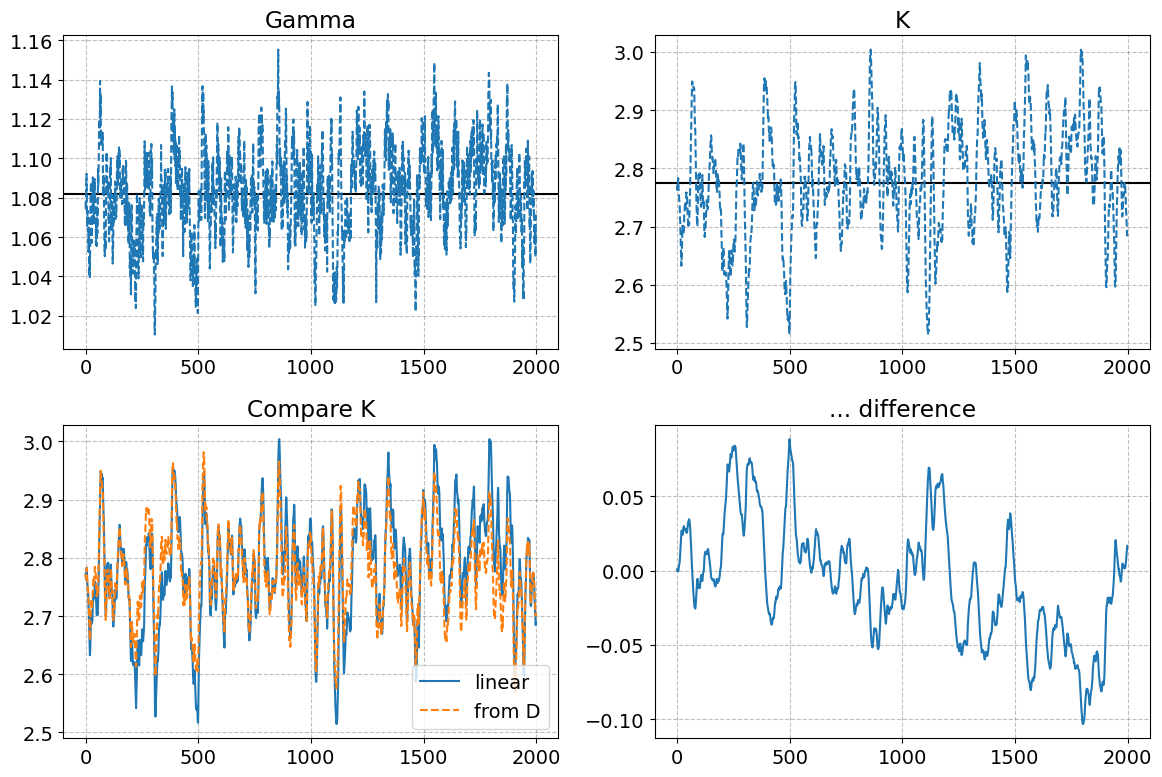

In [61]:
model_sim()

## 12. <a id='toc12_'></a>[Changing unknowns, shocks and targets](#toc0_)

We can update the **update aggregate settings** and automatically reallocate everything, where we consider $L$ as a shock:

In [62]:
model.find_transition_path(shocks=['Gamma'])

In [63]:
model_ = model.copy()
model_.update_aggregate_settings(unknowns=['K'],shocks=['Gamma','L'],targets=['clearing_A'])

We get the exact same results:

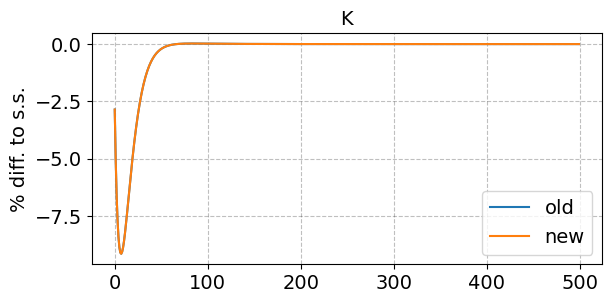

In [64]:
model_.compute_jacs()
model_.find_transition_path(shocks=['Gamma'])
model.compare_IRFs([model,model_],['old','new'],varnames=['K'],do_shocks=False,do_targets=False)